In [11]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [12]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    return input_values_scaled

# Search N and H

In [13]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter-1\dataset\simulation_results_new.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3

X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512]  # Number of neurons per hidden layer

Epoch 1/100, Loss: 0.6215585470199585, Val Loss: 0.3015635907649994
Epoch 2/100, Loss: 0.27512693405151367, Val Loss: 0.24637268483638763
Epoch 3/100, Loss: 0.2689632177352905, Val Loss: 0.2252364307641983
Epoch 4/100, Loss: 0.2686645984649658, Val Loss: 0.22732265293598175
Epoch 5/100, Loss: 0.26700493693351746, Val Loss: 0.22721035778522491
Epoch 6/100, Loss: 0.2623802721500397, Val Loss: 0.2150358408689499
Epoch 7/100, Loss: 0.2569850981235504, Val Loss: 0.2163485437631607
Epoch 8/100, Loss: 0.25438928604125977, Val Loss: 0.208376944065094
Epoch 9/100, Loss: 0.25324952602386475, Val Loss: 0.2122824490070343
Epoch 10/100, Loss: 0.2520880401134491, Val Loss: 0.2074800282716751
Epoch 11/100, Loss: 0.24920761585235596, Val Loss: 0.207810640335083
Epoch 12/100, Loss: 0.2481488436460495, Val Loss: 0.21186836063861847
Epoch 13/100, Loss: 0.24735389649868011, Val Loss: 0.202901691198349
Epoch 14/100, Loss: 0.24584713578224182, Val Loss: 0.2028963416814804
Epoch 15/100, Loss: 0.2443294078111

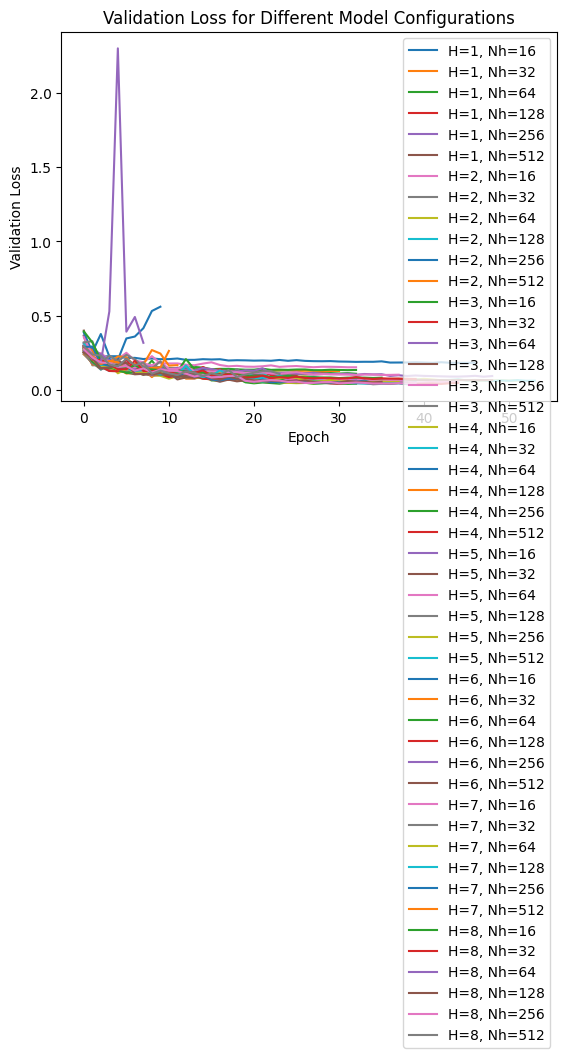

Model with H=1 and Nh=16:
MSE: 0.19229575991630554
MAE: 0.1922958058369555
RMSE: 0.6959239294010895
R-squared: 0.7487156907203604
MAPE: 16.189324613942997%
Model with H=1 and Nh=32:
MSE: 0.1300181746482849
MAE: 0.130018172993162
RMSE: 0.40365159412453
R-squared: 0.8853350083518551
MAPE: 11.809284979395768%
Model with H=1 and Nh=64:
MSE: 0.1364682912826538
MAE: 0.13646828201838307
RMSE: 0.41246911543943826
R-squared: 0.8993211047709715
MAPE: 10.453665859297653%
Model with H=1 and Nh=128:
MSE: 0.1135357916355133
MAE: 0.11353580682122749
RMSE: 0.36389389475882034
R-squared: 0.9436069732731472
MAPE: 8.40961031436495%
Model with H=1 and Nh=256:
MSE: 0.11433665454387665
MAE: 0.11433662856977711
RMSE: 0.3471945829612543
R-squared: 0.9426740682300586
MAPE: 8.905512282011827%
Model with H=1 and Nh=512:
MSE: 0.11748401075601578
MAE: 0.11748401426097094
RMSE: 0.3595376603395193
R-squared: 0.9427697530005245
MAPE: 7.882247502636167%
Model with H=2 and Nh=16:
MSE: 0.1529054194688797
MAE: 0.15290540

In [14]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(3,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(6, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


## Ranking

In [16]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=3, Nh=512 - MSE: 0.040862441062927246
Rank 2: Combination H=6, Nh=128 - MSE: 0.041804611682891846
Rank 3: Combination H=4, Nh=256 - MSE: 0.0426076203584671
Rank 4: Combination H=7, Nh=128 - MSE: 0.044963739812374115
Rank 5: Combination H=8, Nh=256 - MSE: 0.045489102602005005
Rank 6: Combination H=5, Nh=256 - MSE: 0.04759443551301956
Rank 7: Combination H=6, Nh=64 - MSE: 0.048273250460624695
Rank 8: Combination H=5, Nh=512 - MSE: 0.04864589124917984
Rank 9: Combination H=7, Nh=256 - MSE: 0.04933619871735573
Rank 10: Combination H=6, Nh=512 - MSE: 0.04940539970993996
Rank 11: Combination H=3, Nh=256 - MSE: 0.05031948536634445
Rank 12: Combination H=8, Nh=128 - MSE: 0.05172041803598404
Rank 13: Combination H=5, Nh=64 - MSE: 0.05210058391094208
Rank 14: Combination H=6, Nh=256 - MSE: 0.05216766893863678
Rank 15: Combination H=7, Nh=64 - MSE: 0.05385984852910042
Rank 16: Combination H=2, Nh=256 - MSE: 0.05440482124686241
Rank 17: Combination H=4, Nh=128 - MSE: 0.055100

## Try spesific N and H

In [7]:
# Specify the combination you want to call
H = 3
Nh = 512

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model

# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

127/127 [==============================] - 0s 949us/step
Predictions:
[[3.9341521e-02 8.0160922e-01 3.0257163e+00 3.0325563e+00 1.7560620e-02
  2.1559963e+00]
 [1.0542769e+00 4.2008796e+00 1.8223907e+00 1.8367631e+00 6.2692083e-02
  9.8918980e-01]
 [1.6306087e-01 9.1759338e+00 3.4332480e+00 3.4420831e+00 6.2548798e-03
  1.1476246e+00]
 [6.5630317e-02 1.0165424e+00 3.5292690e+00 3.5320411e+00 2.1013534e-02
  9.5791709e-01]
 [2.7290506e-02 1.2319603e+00 3.3183692e+00 3.3149977e+00 1.2712848e-02
  2.1391957e+00]]
True Values:
[[3.73126122e-02 7.47245981e-01 3.03643319e+00 3.03643319e+00
  1.72160434e-02 2.15202491e+00]
 [9.49393284e-01 4.47959053e+00 1.85248205e+00 1.85248205e+00
  7.27748221e-02 1.05888718e+00]
 [1.82801723e-01 9.05225544e+00 3.44051329e+00 3.44051329e+00
  6.14689682e-03 1.17069267e+00]
 [7.21944866e-02 1.01012118e+00 3.53549404e+00 3.53549404e+00
  2.30594268e-02 9.72148356e-01]
 [2.94638994e-02 1.12389005e+00 3.32770238e+00 3.32770238e+00
  1.32762606e-02 2.12984532e+

# Machine Learning

Epoch 1/100, Loss: 0.6320043802261353, Val Loss: 0.43362683057785034
Epoch 2/100, Loss: 0.3529492914676666, Val Loss: 0.1961071789264679
Epoch 3/100, Loss: 0.3124382495880127, Val Loss: 0.15556351840496063
Epoch 4/100, Loss: 0.2990756332874298, Val Loss: 0.1180000826716423
Epoch 5/100, Loss: 0.2903282642364502, Val Loss: 0.13218961656093597
Epoch 6/100, Loss: 0.27831077575683594, Val Loss: 0.10863952338695526
Epoch 7/100, Loss: 0.27694016695022583, Val Loss: 0.12303219735622406
Epoch 8/100, Loss: 0.27010250091552734, Val Loss: 0.13124701380729675
Epoch 9/100, Loss: 0.27093505859375, Val Loss: 0.09795860946178436
Epoch 10/100, Loss: 0.2643207311630249, Val Loss: 0.1641501635313034
Epoch 11/100, Loss: 0.24740271270275116, Val Loss: 0.08924578130245209
Epoch 12/100, Loss: 0.24309273064136505, Val Loss: 0.12763138115406036
Epoch 13/100, Loss: 0.2400674819946289, Val Loss: 0.1489141881465912
Epoch 14/100, Loss: 0.2238432914018631, Val Loss: 0.09599010646343231
Epoch 15/100, Loss: 0.20798753

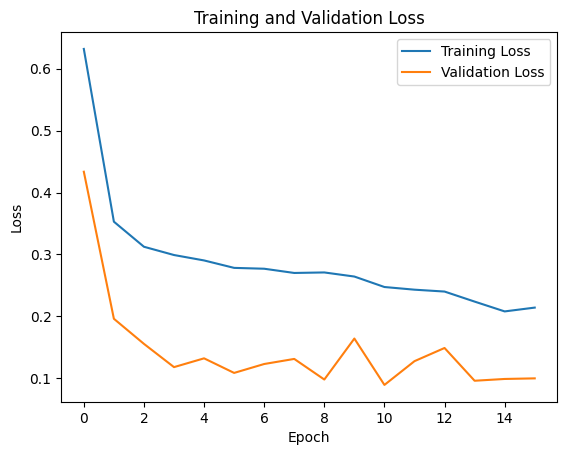

In [9]:
# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter-1\dataset\simulation_results_new.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3

# Apply custom scaling
X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Assuming you have already defined your machine learning model and dataset
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 1
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
])

# model = tf.keras.Sequential([
#     tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 1
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
# ])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model with given hyperparameters
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing Set

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

127/127 [==============================] - 0s 1ms/step - loss: 0.1033
Mean Squared Error on Testing Set: 0.10327570140361786
127/127 [==============================] - 0s 989us/step
Predictions:
[[0.04683643 0.98075175 3.1670532  3.183984   0.01767796 1.9803311 ]
 [0.63571066 5.6320786  1.7932947  1.742603   0.03286593 0.7753885 ]
 [0.09879279 7.26692    3.519491   3.4581873  0.01066541 1.351817  ]
 [0.09455513 1.0213867  3.5961487  3.6080532  0.01899    0.960834  ]
 [0.04262336 1.1857657  3.476276   3.4671586  0.0124905  2.1476464 ]]
True Values:
[[3.73126122e-02 7.47245981e-01 3.03643319e+00 3.03643319e+00
  1.72160434e-02 2.15202491e+00]
 [9.49393284e-01 4.47959053e+00 1.85248205e+00 1.85248205e+00
  7.27748221e-02 1.05888718e+00]
 [1.82801723e-01 9.05225544e+00 3.44051329e+00 3.44051329e+00
  6.14689682e-03 1.17069267e+00]
 [7.21944866e-02 1.01012118e+00 3.53549404e+00 3.53549404e+00
  2.30594268e-02 9.72148356e-01]
 [2.94638994e-02 1.12389005e+00 3.32770238e+00 3.32770238e+00
  1.

## Save Model

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")
